In [ ]:
# !pip install scikeras

In [ ]:
# pip install --upgrade joblib scikit-learn scikeras

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.layers.wrappers.scikit_learn import KerasRegressor
# from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# from functools import partial
# from keras.optimizers import Adam, RMSprop
# import joblib
# from joblib import parallel_backend

In [2]:
# Load your dataset
df = pd.read_csv('processed_data.csv')

Data Cleaning

Data Transformation

In [3]:
# Assuming 'State' and 'Play Type' are the only categorical columns needing encoding
categorical_features = ['Lithology']

In [4]:
# One-hot encoding for the categorical data
one_hot_encoder = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_features)], remainder='passthrough')
df_encoded = one_hot_encoder.fit_transform(df)

In [5]:
# Now df_encoded is a numpy array with one-hot encoded categorical features followed by the rest of the features
# You'll need to convert it back to a DataFrame if you want to keep the column labels
df_encoded = pd.DataFrame(df_encoded, columns=one_hot_encoder.get_feature_names_out())

In [6]:
df_encoded.corr()

,encoder__Lithology_Dolomite,encoder__Lithology_Limestone,encoder__Lithology_Sandstone,remainder__GeologicalFormationThickness(m),remainder__ReservoirThickness(m),remainder__GasPermeability(mD),remainder__LiquidPermeability(mD),remainder__RFC_P10,remainder__RFC_P25,remainder__RFC_P50,remainder__RFC_P75,remainder__RFC_P90
encoder__Lithology_Dolomite,1.000000,-0.017811,-0.311086,-0.009267,-0.005929,0.547861,0.547437,0.442761,0.426286,0.405927,0.383654,0.361612
encoder__Lithology_Limestone,-0.017811,1.000000,-0.944690,0.263757,0.167885,0.025610,0.013204,0.234192,0.249269,0.263434,0.274866,0.283409
encoder__Lithology_Sandstone,-0.311086,-0.944690,1.000000,-0.247670,-0.157635,-0.204050,-0.192119,-0.367840,-0.376767,-0.383553,-0.387114,-0.388004
remainder__GeologicalFormationThickness(m),-0.009267,0.263757,-0.247670,1.000000,0.856153,-0.005857,-0.009913,0.450731,0.485397,0.523825,0.560986,0.593198
remainder__ReservoirThickness(m),-0.005929,0.167885,-0.157635,0.856153,1.000000,-0.014936,-0.015960,0.473340,0.512763,0.558560,0.604770,0.646134
remainder__GasPermeability(mD),0.547861,0.025610,-0.204050,-0.005857,-0.014936,1.000000,0.999835,0.819163,0.788897,0.750954,0.708899,0.666842
remainder__LiquidPermeability(mD),0.547437,0.013204,-0.192119,-0.009913,-0.015960,0.999835,1.000000,0.815563,0.785052,0.746904,0.704708,0.662560
remainder__RFC_P10,0.442761,0.234192,-0.367840,0.450731,0.473340,0.819163,0.815563,1.000000,0.998495,0.992965,0.982898,0.969342
remainder__RFC_P25,0.426286,0.249269,-0.376767,0.485397,0.512763,0.788897,0.785052,0.998495,1.000000,0.997947,0.991424,0.981135
remainder__RFC_P50,0.405927,0.263434,-0.383553,0.523825,0.558560,0.750954,0.746904,0.992965,0.997947,1.000000,0.997745,0.991445


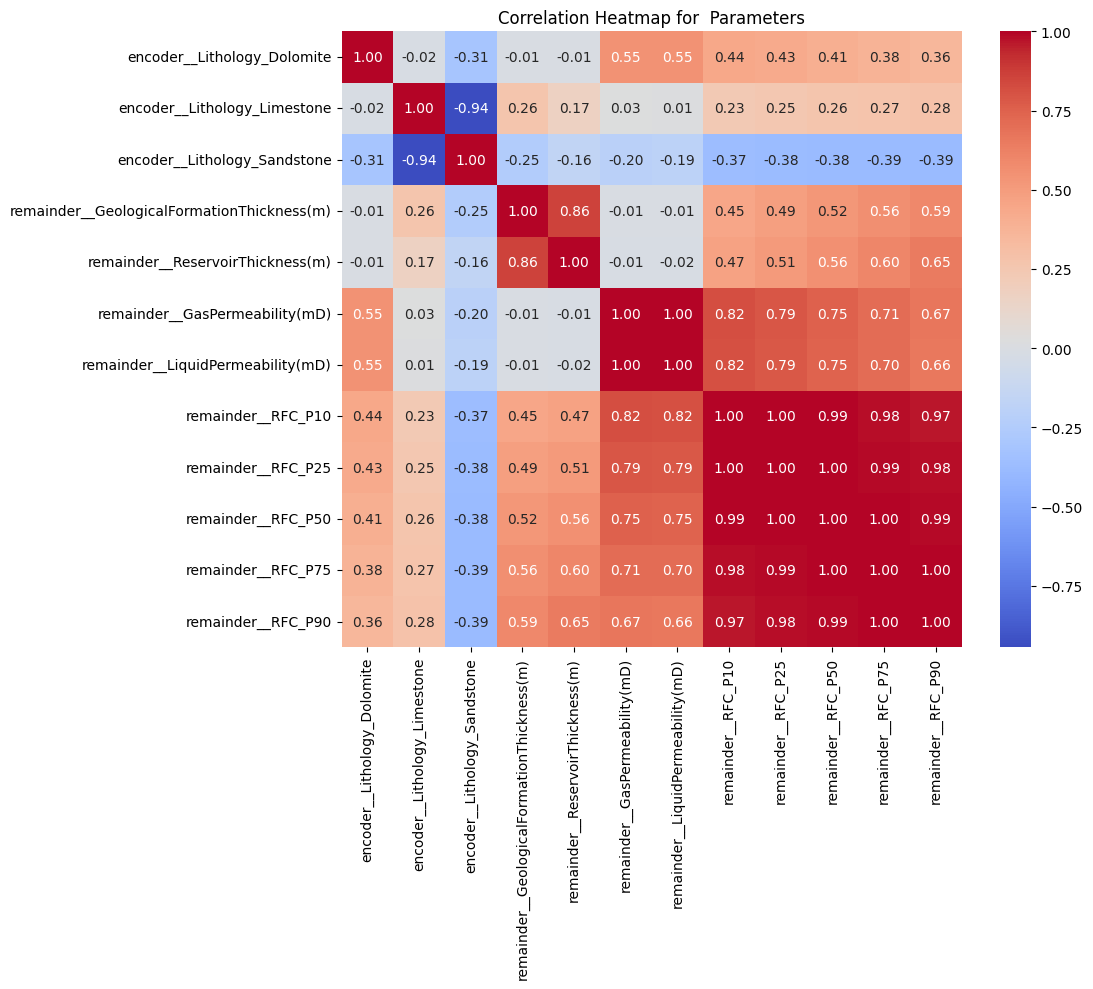

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap for  Parameters')
plt.show()

In [8]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1715 entries, 0 to 1714
Data columns (total 12 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   encoder__Lithology_Dolomite                 1715 non-null   float64
 1   encoder__Lithology_Limestone                1715 non-null   float64
 2   encoder__Lithology_Sandstone                1715 non-null   float64
 3   remainder__GeologicalFormationThickness(m)  1715 non-null   float64
 4   remainder__ReservoirThickness(m)            1715 non-null   float64
 5   remainder__GasPermeability(mD)              1715 non-null   float64
 6   remainder__LiquidPermeability(mD)           1715 non-null   float64
 7   remainder__RFC_P10                          1715 non-null   float64
 8   remainder__RFC_P25                          1715 non-null   float64
 9   remainder__RFC_P50                          1715 non-null   float64
 10  remainder__R

Split to text and train

In [9]:
# Using iloc to separate features and targets
X = df_encoded.iloc[:, :7].values  # Selects all rows and columns up to but not including the 7th index
y = df_encoded.iloc[:, 9:10].values  # Targets are from the 7th column to the end

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
n_features = X.shape[1]

ANN Model Training

In [25]:
# Define the model
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(y_train.shape[1], activation='linear')  # Output layer for regression
# ])


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='linear')  # Output layer for regression
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
# Compile the model with learning rate and gradient clipping
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [27]:
# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

In [28]:
# Train the model
# Fit the model and save the history
history = model.fit(
    X_train_scaled, y_train,
    epochs=1000,
    batch_size=32,
    validation_split=0.2,
    verbose=1,  # Set to 1 if you want to see the progress for each epoch
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 521544.0938 - val_loss: 24657.5977 - learning_rate: 0.0010
Epoch 2/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 625870.1875 - val_loss: 21620.1934 - learning_rate: 0.0010
Epoch 3/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 465295.5625 - val_loss: 18907.9629 - learning_rate: 0.0010
Epoch 4/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 577585.5000 - val_loss: 18966.7715 - learning_rate: 0.0010
Epoch 5/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 328061.9688 - val_loss: 16177.8379 - learning_rate: 0.0010
Epoch 6/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 180209.6719 - val_loss: 6955.7222 - learning_rate: 0.0010
Epoch 7/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 122243.9453 - val_loss: 6827.0859 - learning_rate: 0.0010
Epoch 8/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 146728.7188 - val_loss: 6837.8257 - learning_rate: 0.0010
Epoch 9/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

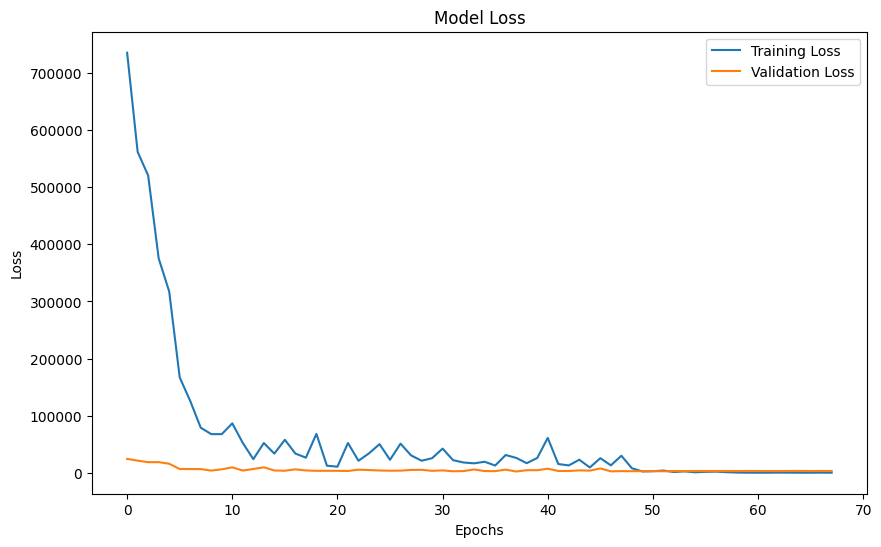

In [29]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [30]:
# Predictions can be made with model.predict(X_test_scaled)
predictions = model.predict(X_test_scaled)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [31]:
# Now calculate the mean squared error (MSE) between the test labels and the predictions
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r_squared = r2_score(y_test, predictions)
explained_variance = explained_variance_score(y_test, predictions)

In [32]:
print("R-squared:", r_squared)
print("Mean Squared Error on Test Set:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("Explained Variance Score:", explained_variance)

R-squared: 0.8459669031698185
Mean Squared Error on Test Set: 2690.7891574608984
Root Mean Squared Error: 51.87281713441924
Mean Absolute Error: 13.65641192065136
Explained Variance Score: 0.8502176626572262


In [33]:
# Create a DataFrame to compare predictions side by side
comparison_df = pd.DataFrame({
    'Actual': y_test.flatten(),  # Flatten y_test if it's multi-dimensional
    'Predicted': predictions.flatten()  # Flatten predictions if necessary
})

# Display the first few rows of the DataFrame to inspect
print(comparison_df.head(30))

       Actual   Predicted
0     0.97426    1.793566
1     1.53090    1.787844
2     2.17370    2.741646
3     1.14440    1.807259
4     0.02093    2.744823
5     2.99180    2.084919
6     0.87474    1.796414
7    19.69200    7.678555
8     1.22200    2.029562
9     0.81330    2.010520
10    1.85530    3.459405
11    0.44057    2.671898
12    1.15070    1.786913
13    1.22200    2.029562
14    1.27820    2.030953
15    0.67821    2.489652
16    1.23660    1.789709
17    0.90910    1.794216
18    1.23660    1.789709
19  150.25000  123.760559
20    1.22200    2.029562
21    0.00678    1.864334
22    2.99180    2.084919
23    0.81897    1.816550
24    0.44057    2.671898
25  139.20000  207.991760
26    1.22200    2.029562
27    0.46276    2.907706
28    1.86340    2.701473
29    1.34750    1.788510


In [34]:
comparison_df.to_csv('comparison_df8b.csv', index=False)

Visualization

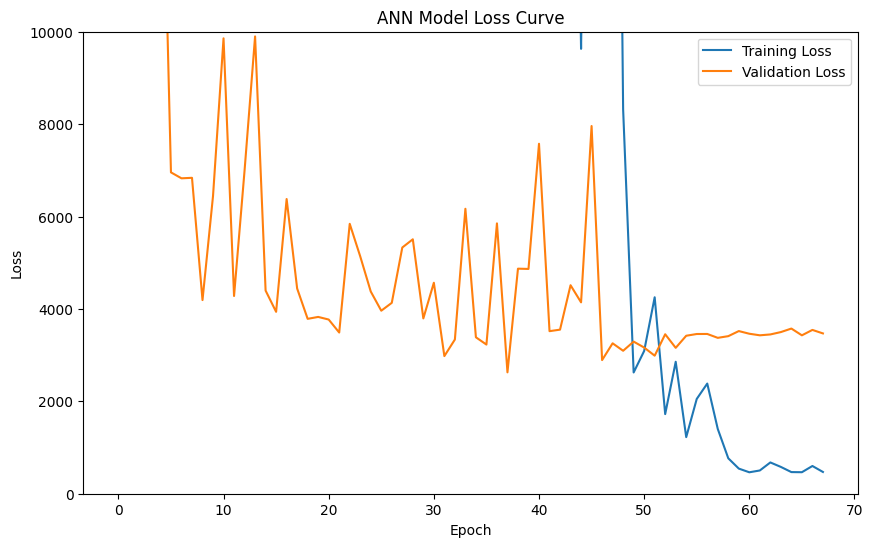

In [35]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ANN Model Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, 10000)
plt.legend()
plt.show()


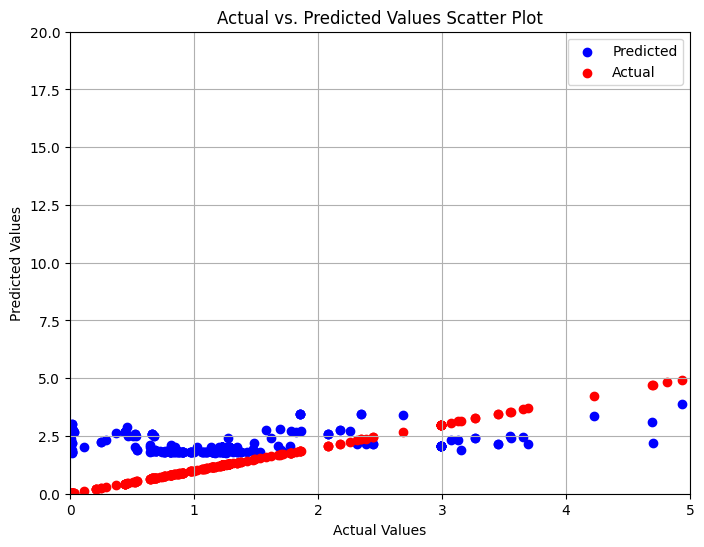

In [36]:
# Create a scatter plot of Actual vs. Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(comparison_df['Actual'], comparison_df['Predicted'], color='blue', label='Predicted')
plt.scatter(comparison_df['Actual'], comparison_df['Actual'], color='red', label='Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values Scatter Plot')
plt.xlim(0, 5)  # Limit x-axis to 20
plt.ylim(0, 20)  # Limit y-axis to 20
plt.legend()
plt.grid(True)
plt.show()